In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Load data
X_scaled = pd.read_csv("../data/processed/X_scaled.csv", dtype='float32')
y = pd.read_csv("../data/processed/y.csv", dtype='int8').squeeze()

# Load selected features
with open("../data/processed/selected_features.json") as f:
    selected_features = json.load(f)

# Ambil kolom fitur terpilih
X_selected = X_scaled[selected_features]

In [4]:
# Split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

Train: (1771951, 30)
Val  : (442988, 30)
Test : (553735, 30)


In [22]:
# Inisialisasi model
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    verbose=50
)

# Training dengan validation set
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'valid'],
    eval_metric='logloss',
    callbacks=[early_stopping(stopping_rounds=50)]
)

# Evaluasi
y_pred = lgbm.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 1435443, number of negative: 336508
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.882048
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.294877
[LightGBM] [Debug] init for col-wise cost 0.065878 seconds, init for row-wise cost 0.382127 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 6512
[LightGBM] [Info] Number of data points in the train set: 1771951, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810092 -> initscore=1.450607
[LightGBM] [Info] Start training from score 1.450607
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
Training until validation scores don't improve for 50 rounds
[LightGBM

In [23]:
from sklearn.metrics import accuracy_score

# Prediksi train & val
y_train_pred = lgbm.predict(X_train)
y_val_pred = lgbm.predict(X_val)
y_test_pred = lgbm.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Val Accuracy  :", accuracy_score(y_val, y_val_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))


Train Accuracy: 0.9997398347922714
Val Accuracy  : 0.999618499823923
Test Accuracy : 0.9996261749753944


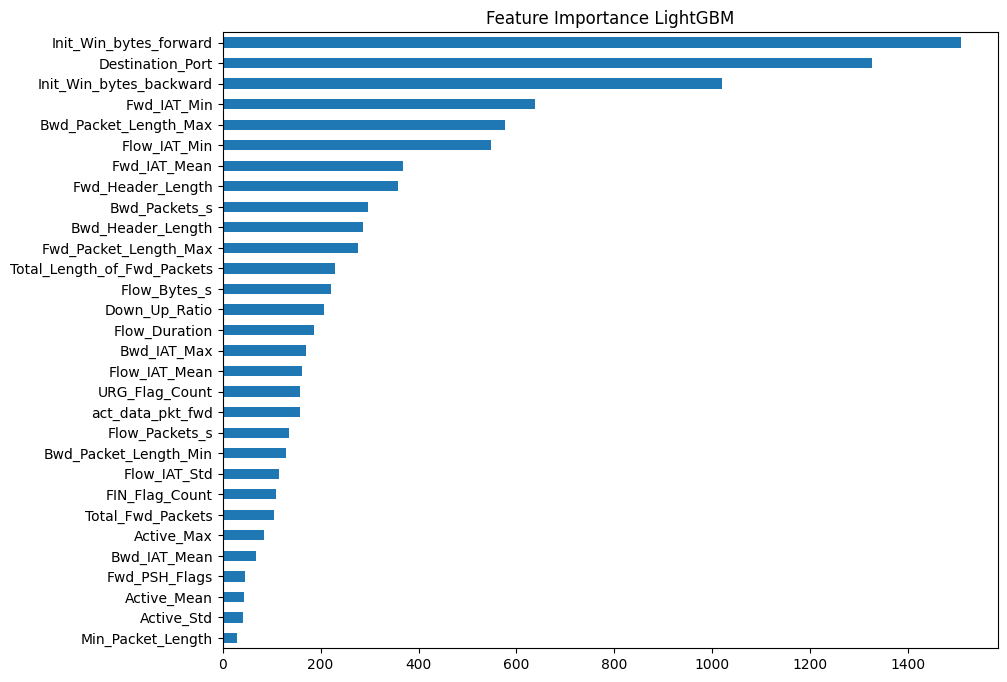

In [16]:


importances = pd.Series(lgbm.feature_importances_, index=X_selected.columns)
importances.sort_values().plot(kind='barh', figsize=(10,8))
plt.title("Feature Importance LightGBM")
plt.show()


In [24]:
from sklearn.metrics import classification_report

y_pred = lgbm.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105159
           1       1.00      1.00      1.00    448576

    accuracy                           1.00    553735
   macro avg       1.00      1.00      1.00    553735
weighted avg       1.00      1.00      1.00    553735



C:\Users\BINTANG PANDU\AppData\Local\Temp\ipykernel_15864\2211920714.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='gray')


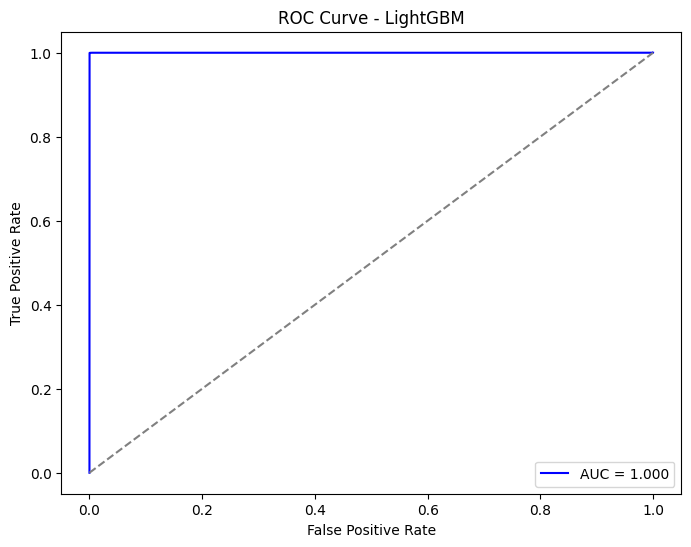

AUC Score: 1.000


In [18]:
from sklearn.metrics import roc_curve, auc

# Probabilitas prediksi untuk kelas 1
y_prob = lgbm.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='blue')
plt.plot([0,1], [0,1], 'k--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.show()

print(f"AUC Score: {roc_auc:.3f}")


In [19]:
from sklearn.metrics import classification_report

# Prediksi di train, val, test
y_train_pred = lgbm.predict(X_train)
y_val_pred = lgbm.predict(X_val)
y_test_pred = lgbm.predict(X_test)

print("📊 Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("📊 Val Classification Report:")
print(classification_report(y_val, y_val_pred))

print("📊 Test Classification Report:")
print(classification_report(y_test, y_test_pred))


📊 Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    336508
           1       1.00      1.00      1.00   1435443

    accuracy                           1.00   1771951
   macro avg       1.00      1.00      1.00   1771951
weighted avg       1.00      1.00      1.00   1771951

📊 Val Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84127
           1       1.00      1.00      1.00    358861

    accuracy                           1.00    442988
   macro avg       1.00      1.00      1.00    442988
weighted avg       1.00      1.00      1.00    442988

📊 Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105159
           1       1.00      1.00      1.00    448576

    accuracy                           1.00    553735
   macro avg       1.00      1.00     

In [31]:
from sklearn.metrics import log_loss

y_train_pred_prob = lgbm.predict_proba(X_train)[:,1]
y_val_pred_prob   = lgbm.predict_proba(X_val)[:,1]

train_loss = log_loss(y_train, y_train_pred_prob)
val_loss   = log_loss(y_val, y_val_pred_prob)

print("Train LogLoss:", train_loss)
print("Validation LogLoss:", val_loss)


Train LogLoss: 0.0008435667810976717
Validation LogLoss: 0.0011986965164691918


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


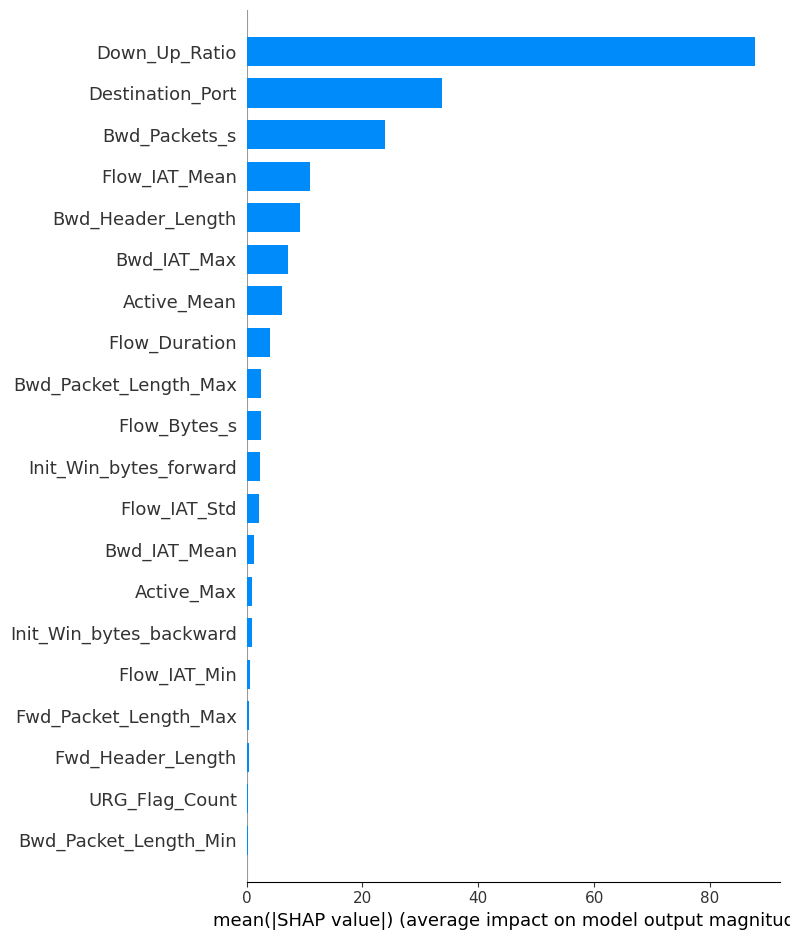

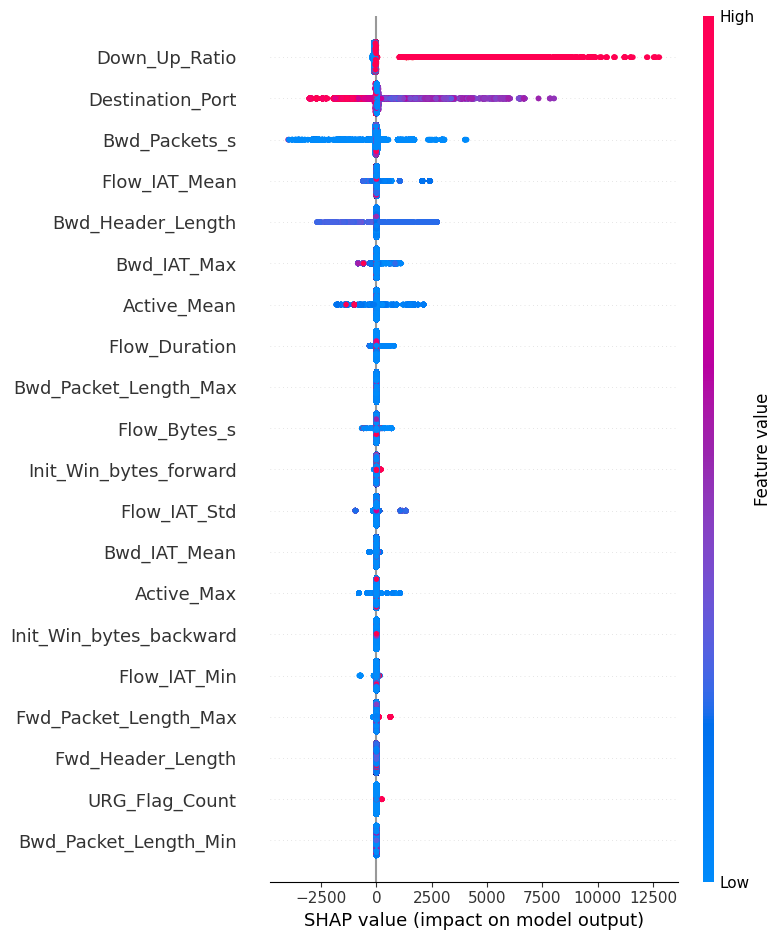

In [33]:
import shap
import numpy as np

# Inisialisasi explainer
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

# Plot summary global
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot summary beeswarm (detail kontribusi tiap sample)
shap.summary_plot(shap_values, X_test)


In [35]:
X_selected[['Init_Win_bytes_forward', 'Destination_Port']].head()


,Init_Win_bytes_forward,Destination_Port
0,-0.02661,140.474365
1,-0.02710,140.958969
2,-0.02710,140.961533
3,-0.02685,118.348717
4,-0.02673,140.469223


In [37]:
# Gabungkan X_selected dan y jadi satu dataframe
df = X_selected.copy()
df["Label"] = y

# Cek bentuk dataframe
print(df.shape)
print(df.head())

print(df.groupby('Label')[['Init_Win_bytes_forward', 'Destination_Port']].mean())
print(df.groupby('Label')[['Init_Win_bytes_forward', 'Destination_Port']].std())


(2768674, 31)
   Init_Win_bytes_forward  Destination_Port  Init_Win_bytes_backward  \
0                -0.02661        140.474365                  0.00000   
1                -0.02710        140.958969                  1.08898   
2                -0.02710        140.961533                  1.08898   
3                -0.02685        118.348717                  1.39831   
4                -0.02673        140.469223                  0.00000   

   Bwd_Packet_Length_Max  Fwd_IAT_Min  Flow_IAT_Min  Fwd_Header_Length  \
0               -0.11307       0.0000      -0.01724           -0.26087   
1               -0.10553      -0.0625       1.81034           -0.47826   
2               -0.10553      -0.0625       0.82759           -0.47826   
3               -0.10553      -0.0625       0.51724           -0.47826   
4               -0.11307       0.0000      -0.01724           -0.26087   

   Fwd_IAT_Mean  Bwd_Header_Length  Total_Length_of_Fwd_Packets  ...  \
0      -0.00006           -0.43478  

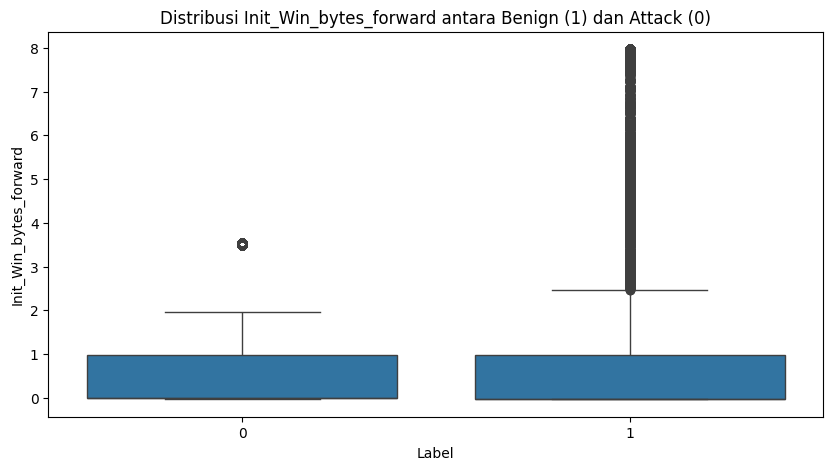

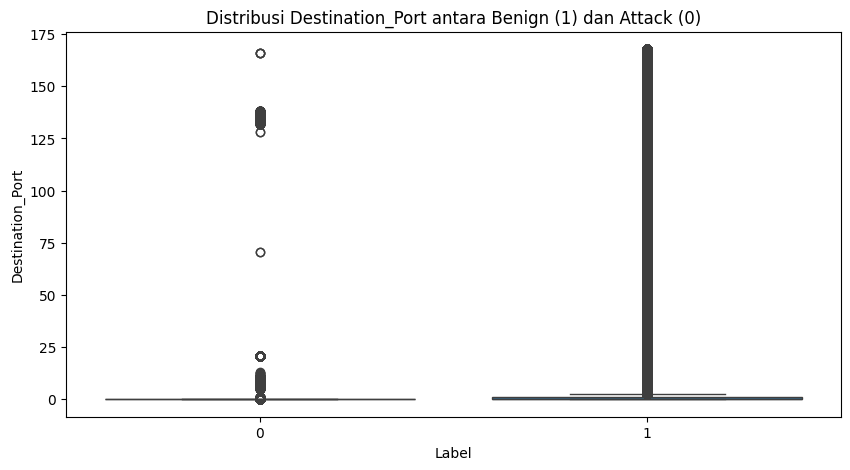

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Label', y='Init_Win_bytes_forward')
plt.title("Distribusi Init_Win_bytes_forward antara Benign (1) dan Attack (0)")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Label', y='Destination_Port')
plt.title("Distribusi Destination_Port antara Benign (1) dan Attack (0)")
plt.show()


In [40]:
# Probabilitas kelas 1
y_proba = lgbm.predict_proba(X_test)[:,1]

# Prediksi label (threshold 0.5)
y_pred = lgbm.predict(X_test)


In [43]:
mae = mean_absolute_error(y_test, y_proba)
mse = mean_squared_error(y_test, y_proba)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_proba)

print(f"MAE  : {mae:.6f}")
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")


MAE  : 0.000632
MSE  : 0.000283
RMSE : 0.016811
R²   : 0.998163


In [44]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")


Confusion Matrix:
[[105102     57]
 [   150 448426]]
TP: 448426, FP: 57, FN: 150, TN: 105102


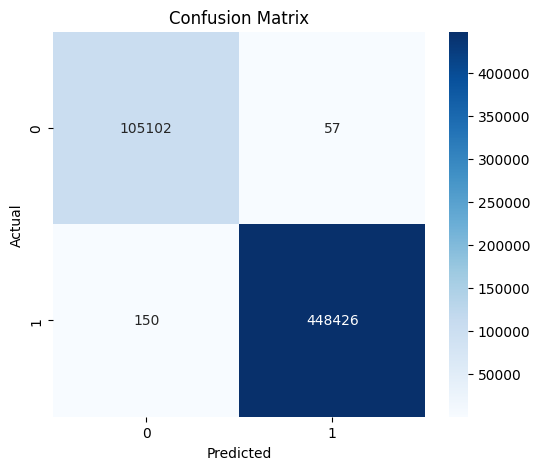

In [45]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Definisi TP TN FP FN

#### (kelas 0 = serangan, kelas 1 = normal/Benign)


#### 1. TP (True Positive) = 448,426 → model benar memprediksi kelas 1

#### 2. TN (True Negative) = 105,102 → model benar memprediksi kelas 0

#### 3. FP (False Positive) = 57 → model salah memprediksi kelas 0 sebagai 1

#### 4. FN (False Negative) = 150 → model salah memprediksi kelas 1 sebagai 0

In [46]:
import numpy as np
unique, counts = np.unique(lgbm.predict(X_test), return_counts=True)
print("Prediksi distribusi (label:count):", dict(zip(unique, counts)))


Prediksi distribusi (label:count): {np.int8(0): np.int64(105252), np.int8(1): np.int64(448483)}


In [47]:
from sklearn.metrics import precision_recall_curve, auc
y_prob = lgbm.predict_proba(X_test)[:,1]
prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(rec, prec)
print("PR AUC:", pr_auc)


PR AUC: 0.9999863460751532


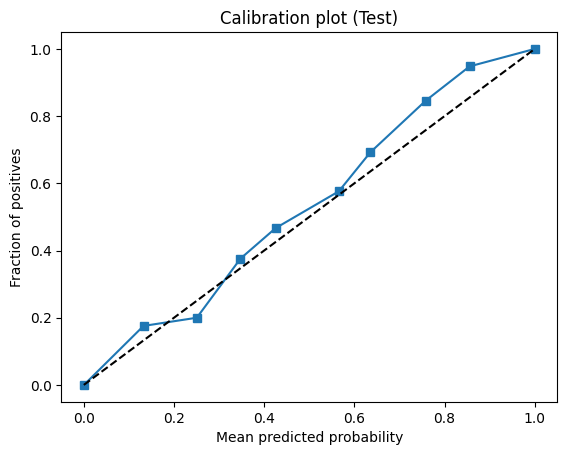

In [48]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_pos = y_prob
frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)

plt.plot(mean_pred, frac_pos, "s-")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot (Test)")
plt.show()


In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = []
for train_idx, val_idx in skf.split(X_selected, y):   # pakai X_selected jika ada
    Xtr, Xv = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
    ytr, yv = y.iloc[train_idx], y.iloc[val_idx]
    model = LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1)
    model.fit(Xtr, ytr)
    aucs.append(roc_auc_score(yv, model.predict_proba(Xv)[:,1]))
print("CV AUCs:", aucs, "mean:", np.mean(aucs))


[LightGBM] [Info] Number of positive: 1794304, number of negative: 420635
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.883288
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.295227
[LightGBM] [Debug] init for col-wise cost 0.081299 seconds, init for row-wise cost 0.610571 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 6508
[LightGBM] [Info] Number of data points in the train set: 2214939, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810092 -> initscore=1.450607
[LightGBM] [Info] Start training from score 1.450607
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[Light